In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
def dataload(data):
    Pk0 = [[],[]]
    Pk2 = [[],[]]
    k = data[0,:,1]
    l0 = data[:,:,3]
    l2 = data[:,:,4]
    Pk0[0] = np.mean(l0,axis=0)
    Pk0[1] = np.std(l0,axis=0)
    Pk2[0] = np.mean(l2,axis=0)
    Pk2[1] = np.std(l2,axis=0)
    pk_cov = np.append(l0,l2,axis=1)
    cov = np.cov(np.array(pk_cov).T)
    icov = np.linalg.inv(cov)
    return (k,Pk0,Pk2,icov)

def Pkload():
    # load the QUIJOTE observation
    tool = 'Pypower' # Powspec, Pypower, NCV
    Ddir = f'/Users/alain/Desktop/projectNU/main/data/Pypower/fiducial/RSD_z1.0/pk'
    data = []
    nb = np.arange(100,200,1)
    for h in nb:
        realisation=np.loadtxt(Ddir+f'/fiducial_{h}_z1.0.pk')
        data.append(realisation)
    (kev, pk0, pk2, icov) = dataload(np.array(data))
    pkl = [kev, pk0, pk2, icov]
    return pkl

In [3]:
import RSDmodel as RSD
from nautilus import Prior, Sampler

(k_data, pk0, pk2, icov) = Pkload()
pk_data = np.append(pk0[0], pk2[0])
k_ev = k_data

def Nprior():
    prior = Prior()
    param_names = ['h', 'omega_cdm', 'logA', 'Mnu', 'b1', 'b2', 'alpha0', 'alpha2', 'sn0', 'sn2']
    prior.add_parameter('h', dist=(0.1, 0.9))
    prior.add_parameter('omega_cdm', dist=(0.05, 0.4))
    prior.add_parameter('logA', dist=(2, 4))
    prior.add_parameter('Mnu', dist=(0.0, 2.0))
    prior.add_parameter('b1', dist=(-10, 10))
    prior.add_parameter('b2', dist=(-10, 10))
    prior.add_parameter('alpha0', dist=(-300, 300))
    prior.add_parameter('alpha2', dist=(-300, 300))
    prior.add_parameter('sn0', dist=(-5, 5))
    prior.add_parameter('sn2', dist=(-50, 50))
    return prior

def likelihood(param_dict):
    p = np.array([param_dict['h'], param_dict['omega_cdm'],param_dict['logA'], param_dict['Mnu']
                  ,param_dict['b1'],param_dict['b2'],param_dict['alpha0'],param_dict['alpha2'],param_dict['sn0'],param_dict['sn2']])
    #define log likelihood
    (k_model,pkl0_model,pkl2_model) = RSD.FOLPSmultiples(p,k_ev)
    pk_model = np.append(pkl0_model,pkl2_model)
    diff = pk_data-pk_model
    chisquare = np.dot(diff,np.dot(icov,diff)) 
    logL = -0.5*chisquare
    #returning the natural logarithm of the likelihood. log(L) = -0.5*chi^2
    return logL

N = 128 sampling points
M matrices have been computed


In [4]:
sampler = Sampler(Nprior(), likelihood, n_live=1000,
    filepath='/Nautilus_result/', resume=True)
sampler.run(verbose=True)

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    


/Users/alain/opt/anaconda3/lib/python3.9/site-packages/scipy/special/_logsumexp.py:110: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)
/Users/alain/opt/anaconda3/lib/python3.9/site-packages/nautilus/sampler.py:644: RuntimeWarning: All-NaN slice encountered
  np.nanmax(self.shell_log_l + self.shell_log_v))[select]
/Users/alain/opt/anaconda3/lib/python3.9/site-packages/nautilus/sampler.py:646: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(sum_w)**2 / np.sum(sum_w_sq)


ValueError: zero-size array to reduction operation maximum which has no identity

In [3]:
import RSDmodel as RSD
import emcee

(k_data, pk0, pk2, icov) = Pkload()
pk_data = np.append(pk0[0], pk2[0])

# h, Omega_cdm, Mnu, ln(10^{10}A_s), b1, b2, alpha0, alpha2, alphashot0, alphashot2
# p_kaiser = [h, omega_cdm, logA, b1, sv]
p0 = [0.6711, 0.1209, 3.0631, 2.0, 400]

def log_likelihood(p,k_data,pk_data,icov):
    (h, omega_cdm, logA, b1, sv)= p
    #define prior
    if h<0.5 or h>0.7:
        return -np.inf
    elif omega_cdm<0.05 or omega_cdm>0.2:
        return -np.inf
    elif logA<2 or logA>4:
        return -np.inf
    # Biased tracers -- b1:[1,2], b2:[-5,5]
    elif b1<-5 or b1>5:
        return -np.inf
    elif sv<100 or sv>800:
        return -np.inf
    #define log likelihood
    (kh, Pkl0, Pkl2) = RSD.Kaisermultiples(p, k_data)
    pk_model = np.append(Pkl0, Pkl2)
    diff = pk_data-pk_model
    logL = -0.5*np.dot(diff,np.dot(icov,diff))
    return logL

nwalkers = 50 # need to be at least twice the number of dimension
save_output = True
startpos = p0
pos = startpos + 1e-4 * np.random.randn(nwalkers, len(startpos)) # initialise the walkers
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(k_data,pk_data,icov))
sampler.run_mcmc(pos, 500, progress=True, store=True)

emcee: Exception while calling your likelihood function:
  params: [6.71204200e-01 1.20897760e-01 3.06318179e+00 2.00005474e+00
 4.00000017e+02]
  args: (array([0.008, 0.014, 0.02 , 0.026, 0.032, 0.038, 0.044, 0.05 , 0.056,
       0.062, 0.068, 0.074, 0.08 , 0.086, 0.092, 0.098, 0.104, 0.11 ,
       0.116, 0.122, 0.128, 0.134, 0.14 , 0.146, 0.152, 0.158, 0.164,
       0.17 , 0.176, 0.182, 0.188, 0.194, 0.2  ]), array([60321.61099538, 71764.38276658, 72110.47955228, 63848.04266528,
       53706.46789523, 46698.48719264, 40330.8360877 , 36256.73298296,
       33733.56682468, 31485.37188526, 29340.73033541, 27228.08042694,
       24331.70690965, 21994.20773041, 19715.98978839, 17792.13837996,
       16295.34774592, 15083.69508102, 14339.17292056, 13758.38731561,
       13005.21253903, 12388.16828211, 11633.19405586, 10863.48199591,
       10209.07576773,  9510.56852717,  8996.87100619,  8507.09838736,
        8209.64693798,  7849.29304402,  7563.02492623,  7237.41177065,
        6970.0258

Traceback (most recent call last):
  File "/Users/alain/opt/anaconda3/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/n0/gs1g7p590qg7trf8pp8w29ch0000gn/T/ipykernel_3705/2562729372.py", line 26, in log_likelihood
    (kh, Pkl0, Pkl2) = RSD.Kaisermultiples(p, k_data)
  File "/Users/alain/Desktop/projectNU/main/theory/RSDmodel.py", line 64, in Kaisermultiples
    nonlinear = FOLPS.NonLinear(inputpkT, CosmoParams, EdSkernels = True)
  File "/Users/alain/Desktop/projectNU/main/theory/./FOLPS-nu/FOLPSnu.py", line 828, in NonLinear
    inputfkT = fOverf0EH(z_pk, inputpkT[0], OmM0, h, fnu)
  File "/Users/alain/Desktop/projectNU/main/theory/./FOLPS-nu/FOLPSnu.py", line 513, in fOverf0EH
    Dplusp_ = interp(etaofz(zev), eta, Dplusp)
  File "/Users/alain/Desktop/projectNU/main/theory/./FOLPS-nu/FOLPSnu.py", line 36, in interp
    inter = CubicSpline(x, y)
  File "/Users/alain/opt/anaconda3/lib/python3.9/si

KeyboardInterrupt: 

In [17]:
dir = './mcmc_result'
# reader = emcee.backends.HDFBackend(dir+"./chain.h5", read_only=True)
flatchain = sampler.get_chain(discard=100, thin=20,flat=True)

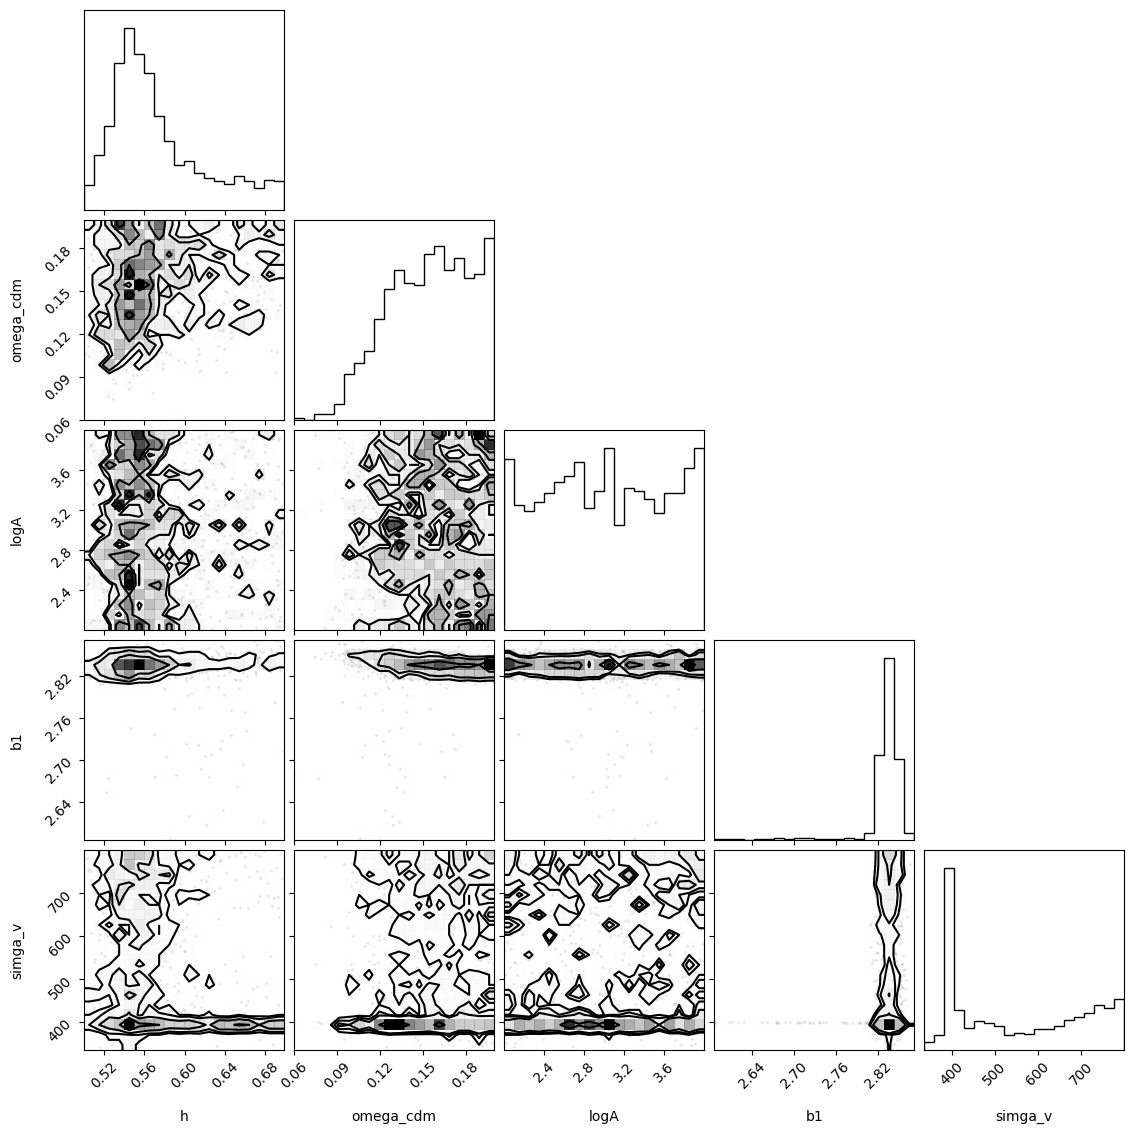

In [18]:
import corner
labels = ["h", "omega_cdm", "logA", "b1", "simga_v"]
fig = corner.corner(flatchain, labels=labels)


In [8]:
import RSDmodel as RSD
import emcee

(k_data, pk0, pk2, icov) = Pkload()
pk_data = np.append(pk0[0], pk2[0])

# h, Omega_cdm, Mnu, ln(10^{10}A_s), b1, b2, alpha0, alpha2, alphashot0, alphashot2
# p_TNS = [h, omega_cdm, logA, b1, b2, sv, sn0, sn2]
p0 = [0.6711, 0.1209, 3.0631, 2.4,  0.9,  400, 0.15, -8]

def log_likelihood(p,k_data,pk_data,icov):
    (h, omega_cdm, logA, b1, b2, sv, sn0, sn2)= p
    #define prior
    if h<0.5 or h>0.7:
        return -np.inf
    elif omega_cdm<0.05 or omega_cdm>0.2:
        return -np.inf
    elif logA<2 or logA>4:
        return -np.inf
    # Biased tracers -- b1:[1,2], b2:[-5,5]
    elif b1<-5 or b1>5:
        return -np.inf
    elif b1<-5 or b1>5:
        return -np.inf
    elif sv<100 or sv>800:
        return -np.inf
    elif sn
    #define log likelihood
    (kh, Pkl0, Pkl2) = RSD.TNSmultiples(p, k_data)
    pk_model = np.append(Pkl0, Pkl2)
    diff = pk_data-pk_model
    logL = -0.5*np.dot(diff,np.dot(icov,diff))
    return logL

nwalkers = 50 # need to be at least twice the number of dimension
save_output = True
startpos = p0
pos = startpos + 1e-4 * np.random.randn(nwalkers, len(startpos)) # initialise the walkers
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(k_data,pk_data,icov))
sampler.run_mcmc(pos, 500, progress=True, store=True)

SyntaxError: invalid syntax (3989646887.py, line 27)